In [1]:
import warnings

warnings.simplefilter("ignore")


In [2]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True

import numpy as np
from sklearn.metrics import mean_squared_log_error

## Linear regression
In this example we'll work with synthetic data with noise. The target is to get the model that best fits the data.

The data is generated using the following function.
$$f(x) = 4 + 3 x$$

The gaussian noise to the target to simulate the noise in the real dataset. So we have 
$$y = f(x) + \mathcal{N}(\mu=0,\,\sigma^{2}=1)$$

We'd like to train a model to learn the relation between the input and the output of the data. We can safely assume that the relation is linear, because we generated the data using linear function.
The model we're going to use is defined as follows,
$$\hat{y} = h_{\theta}(x) = \theta_0 + \theta_1 * x$$

Let's see if we can estimate the original coefficients, i.e., $\theta_0=4$ and $\theta_0=3$, that are used to generate the data.

In [3]:
# Data generation
np.random.seed(42)

ADD_OUTLIERS = False

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance

if ADD_OUTLIERS:
    y[np.random.randint(100, size=20)] += np.random.randint(-5, 5, size=(20, 1))

In [4]:
# Points to do prediction on 
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance

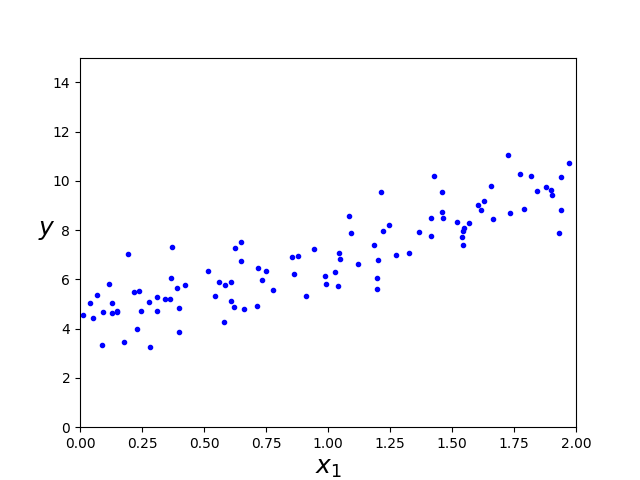

In [5]:
plt.figure()
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15]);


Last time, we learned about measuring the performance of the regression models. One measure you can use is the $RMSE$. It's easier to use the $MSE$ as a cost function to optimize. Using both will yeild the same result.

$$RMSE(X,h)=\sqrt{\frac{\sum_{i=1}^M (h(x^{(i)})-y^{(i)})^2}{M}}$$
$$MSE(X,h)=\frac{\sum_{i=1}^M (h(x^{(i)})-y^{(i)})^2}{M}$$

Another cost function we can use is the Mean Absolute Error $MAE$.
$$MAE(X,h)=\frac{\sum_{i=1}^M |h(x^{(i)})-y^{(i)}|}{M}$$

### The effect of changing the parameters
Let's see how the model and the cost change when we change the parameters of the model.

interactive(children=(FloatSlider(value=3.0, description='theta_0', max=10.0), FloatSlider(value=0.0, descript…

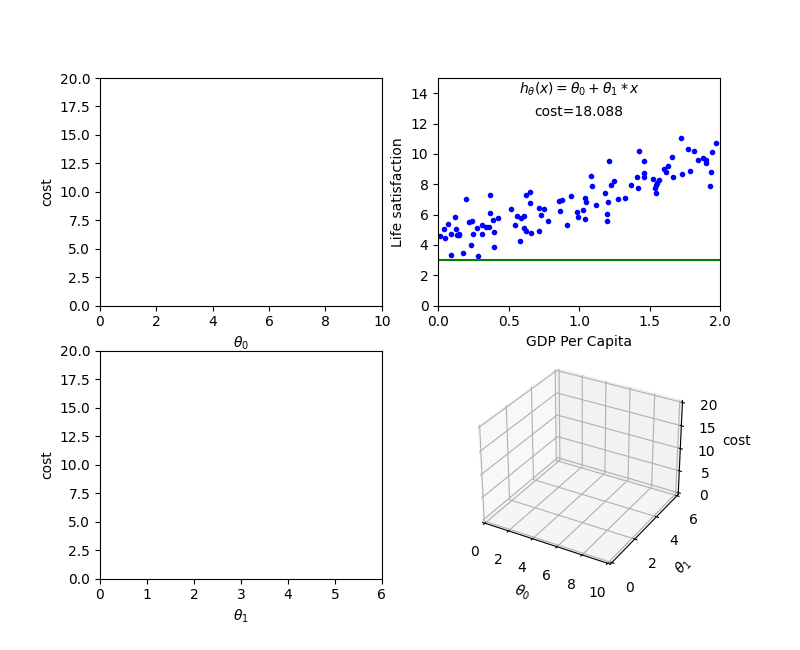

In [6]:
fig = plt.figure(figsize=(8, 6.5))

LIMITS = {
    "theta_0": [0, 10],
    "theta_1": [0,  6],
    "cost_l2"   : [0, 20],
    "cost_l1"   : [0, 10],
    "cost_log_e"   : [0, 2],
    "data_x" : [0,  2],
    "data_y" : [0, 15]
    
}

axes = {
    "loss_theta0": fig.add_subplot(2, 2, 1),
    "model": fig.add_subplot(2, 2, 2),
    "loss_theta1": fig.add_subplot(2, 2, 3),
    "loss_3d": fig.add_subplot(2, 2, 4, projection='3d'),
}
axes["model"].text(0.5, 0.95,r'$h_{\theta}(x) = \theta_0+\theta_1*x$', horizontalalignment='center',
     verticalalignment='center',
     transform=axes["model"].transAxes)
axes["model"].text(0.5, 0.85,r'cost=    ', horizontalalignment='center',
         verticalalignment='center',
         transform=axes["model"].transAxes)

def set_axes_limits(l_func="l2"):
    axes["model"].set_xlim(LIMITS["data_x"])
    axes["model"].set_ylim(LIMITS["data_y"])
    axes["model"].set_xlabel("GDP Per Capita")
    axes["model"].set_ylabel("Life satisfaction")
    axes["loss_theta0"].set_xlabel(r"$\theta_0$")
    axes["loss_theta0"].set_ylabel("cost")
    axes["loss_theta1"].set_xlabel(r"$\theta_1$")
    axes["loss_theta1"].set_ylabel("cost")
    axes["loss_3d"].set_xlabel(r"$\theta_0$")
    axes["loss_3d"].set_ylabel(r"$\theta_1$")
    axes["loss_3d"].set_zlabel("cost")

    if l_func == "MSE":
        axes["loss_theta0"].set_xlim(LIMITS["theta_0"])
        axes["loss_theta0"].set_ylim(LIMITS["cost_l2"])
        axes["loss_theta1"].set_xlim(LIMITS["theta_1"])
        axes["loss_theta1"].set_ylim(LIMITS["cost_l2"])
        axes["loss_3d"].set_xlim(LIMITS["theta_0"])
        axes["loss_3d"].set_ylim(LIMITS["theta_1"])
        axes["loss_3d"].set_zlim(LIMITS["cost_l2"])
    elif l_func == "MAE":
        axes["loss_theta0"].set_xlim(LIMITS["theta_0"])
        axes["loss_theta0"].set_ylim(LIMITS["cost_l1"])
        axes["loss_theta1"].set_xlim(LIMITS["theta_1"])
        axes["loss_theta1"].set_ylim(LIMITS["cost_l1"])
        axes["loss_3d"].set_xlim(LIMITS["theta_0"])
        axes["loss_3d"].set_ylim(LIMITS["theta_1"])
        axes["loss_3d"].set_zlim(LIMITS["cost_l1"])
    else:
        axes["loss_theta0"].set_xlim(LIMITS["theta_0"])
        axes["loss_theta0"].set_ylim(LIMITS["cost_log_e"])
        axes["loss_theta1"].set_xlim(LIMITS["theta_1"])
        axes["loss_theta1"].set_ylim(LIMITS["cost_log_e"])
        axes["loss_3d"].set_xlim(LIMITS["theta_0"])
        axes["loss_3d"].set_ylim(LIMITS["theta_1"])
        axes["loss_3d"].set_zlim(LIMITS["cost_log_e"])


def generic_model(x, theta_0, theta_1):
    return theta_0 + x * theta_1

def get_2xys_on_model(theta_0, theta_1):
    return (LIMITS['data_x'], [generic_model(x, theta_0, theta_1) for x in LIMITS['data_x']])

def calc_loss(x, y, theta_0, theta_1, l_func="MSE"):
    y_preds = np.array([generic_model(xi, theta_0, theta_1) for xi in x])
    if l_func == "MSE":
        e = ((y_preds - y)**2).mean()
    elif l_func == "MAE":
        e = np.abs((y_preds - y)).mean()
    elif l_func == "MSLE":
        y_preds[y_preds<=0] = 0
        e = mean_squared_log_error(y, y_preds)

    return e

def get_loss_points(theta_0=None, theta_1=None, l_func="l2"):
    th0s = np.linspace(*LIMITS['theta_0'], 50)
    th1s = np.linspace(*LIMITS['theta_1'], 50)

    if theta_0 is None and theta_1 is None:
        th0s = np.linspace(*LIMITS['theta_0'], 10)
        th1s = np.linspace(*LIMITS['theta_1'], 10)
        th0s, th1s = np.meshgrid(th0s, th1s)
        mse_loss = np.zeros_like(th0s)
        for i in range(len(th0s)):
            for j in range(len(th1s)):
                mse_loss[i, j] = calc_loss(X, y, th0s[i, j], th1s[i, j], l_func=l_func)
        return th0s, th1s, mse_loss
    elif theta_1 is None:
        xys = [[th1, calc_loss(X, y, theta_0, th1, l_func=l_func)] for th1 in th1s]
        return np.array(xys)
    elif theta_0 is None:
        xys = [[th0, calc_loss(X, y, th0, theta_1, l_func=l_func)] for th0 in th0s]
        return np.array(xys, dtype='float')
        
@widgets.interact(theta_0=(*LIMITS['theta_0'], .1), theta_1=(*LIMITS['theta_1'], .05), loss=["MAE", "MSE", "MSLE"])
def update(theta_0=3, theta_1=0, loss="MSE", show_loss_theta0=False, show_loss_theta1=False, show_loss_3d=False):
    """Remove old lines from plot and plot new one"""
    set_axes_limits(l_func=loss)
    [l.remove() for a in axes.values() for l in a.get_lines()]
    [l.remove() for a in axes.values() for l in a.collections]
    axes['model'].plot(X, y, 'b.')
    axes['model'].plot(*get_2xys_on_model(theta_0, theta_1), 'g')
    [tera.remove() for tera in axes["model"].texts[1:]]
    axes["model"].text(0.5, 0.85,r'cost={:2.03f}'.format(calc_loss(X, y, theta_0, theta_1, l_func=loss)), horizontalalignment='center',
         verticalalignment='center',
         transform=axes["model"].transAxes)
    if show_loss_theta0:
        axes['loss_theta0'].plot(*get_loss_points(theta_1=theta_1, l_func=loss).T, 'b')
        axes['loss_theta0'].plot([theta_0], [calc_loss(X, y, theta_0, theta_1, l_func=loss)], 'r.', markersize=12)
    if show_loss_theta1:
        axes['loss_theta1'].plot(*get_loss_points(theta_0=theta_0, l_func=loss).T, 'b')
        axes['loss_theta1'].plot([theta_1], [calc_loss(X, y, theta_0, theta_1, l_func=loss)], 'r.', markersize=12)
    if show_loss_3d:
        loss_3d_x, loss_3d_y, loss_3d_z = get_loss_points(l_func=loss)
        surf = axes['loss_3d'].plot_wireframe(loss_3d_x, loss_3d_y, loss_3d_z, cmap='jet')
        surf.set_facecolor((0,0,0,0))
        axes['loss_3d'].plot([theta_0], [theta_1], [calc_loss(X, y, theta_0, theta_1, l_func=loss)], 'r.', markersize=20)


Using the tool, can you guess the parameters values that best describes the data when evaluated by $MSE$?

$$\theta_0=4.20$$
$$\theta_1=2.80$$

What if we change the cost function to $MAE$?

$$\theta_0=??$$
$$\theta_1=??$$

Can you do the same with `ADD_OUTLIERS`'s value is `True` in the cell we generated the data?

MSE
$$\theta_0=??$$
$$\theta_1=??$$

MAE
$$\theta_0=??$$
$$\theta_1=??$$


In [7]:
plt.close()

### Gradient Descent

Now that we saw the effect of changing the parameters on the model and the cost function, and manually estimated the values of the parameters, can we use an algorithm to do that?

Let's image we have an imaginary cost function $cost(x)=2x^2-3^x+10$. This is a quadratic function which is the type of cost function you'll get when you use $MSE$.

How can we get the value of $x$ that minimizes the cost?

In [8]:
cost_example = "qu"

cost_qu_func = lambda x: 2*x**2+-3*x+10
cost_abs_func = lambda x: abs(-3*x+10) + 2
cost_bad_func = lambda x: (-7200*x + 3420*x**2 - (2452*x**3)/3 + (207*x**4)/2 - (33*x**5)/5 + x**6/6)/80 + 78

if cost_example == "qu":
    cost_func = cost_qu_func

    LIMITS = {
        "theta": [-10, 10] ,
        "cost": [0,  40]    
    }
elif cost_example == "abs":
    cost_func = cost_abs_func

    LIMITS = {
        "theta": [-10, 10] ,
        "cost": [0,  20]    
    }
elif cost_example == "bad":
    cost_func = cost_bad_func

    LIMITS = {
        "theta": [1, 12] ,
        "cost": [0,  10]    
    }

interactive(children=(FloatSlider(value=-1.0, description='x_0', max=12.0, min=-10.0, step=0.05), FloatSlider(…

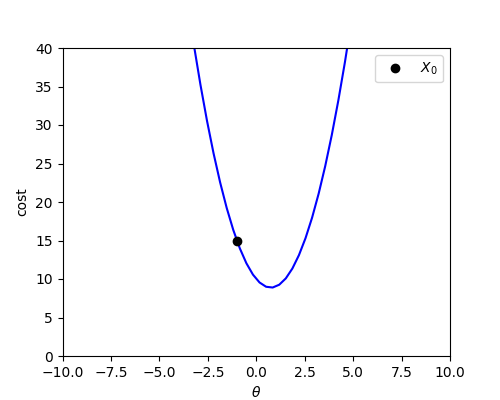

In [9]:

fig = plt.figure(figsize=(5, 4))
axes = {
    "cost": fig.add_subplot(),
}

axes["cost"].set_xlim(LIMITS["theta"])
axes["cost"].set_ylim(LIMITS["cost"])
axes["cost"].set_xlabel(r"$\theta$")
axes["cost"].set_ylabel("cost")

def func_to_optimize(x):
    return 0.5*x**2+-3*x+10

def get_xys_on_func():
    return np.asarray([(x, cost_func(x)) for x in np.linspace(*LIMITS['theta'], 60)])

def calc_slope(x, dx):
    return (cost_func(x+dx) - cost_func(x))/dx

def slope_line_func(x, x_0, dx):
    m = calc_slope(x_0, dx)
    b = cost_func(x_0) - m * x_0
    return m*x+b

def get_xys_opt(x_0, lr, steps, momentum):
    eta = 0.1  # learning rate
    n_iterations = 1000
    m = 100

    theta = np.random.randn(2,1)  # random initialization
    x_new = x_0
    opt_steps = []
    update_val = 0
    for step in range(steps):
        opt_steps.append([x_new, cost_func(x_new)])
        gradient = calc_slope(x_new, 1e-5)
        update_val = lr * gradient + momentum * update_val
        x_new = x_new - update_val
    return np.asarray(opt_steps)
        
        
@widgets.interact(x_0=(-10,12,0.05), dx=(0.0001, 10, 0.1), lr=(0.001, 1, 0.01), steps=(1, 20, 1), momentum=(0, 1, 0.05))
def update(x_0=-1, dx=0.5, lr=0.1, steps=5, momentum=0, show_xdx=False, show_line=False, show_optimization_steps=False):
    """Remove old lines from plot and plot new one"""
    [l.remove() for a in axes.values() for l in a.get_lines()]
    [c.remove() for a in axes.values() for c in a.collections]
    [t.remove() for t in axes["cost"].texts]
    axes['cost'].plot(*get_xys_on_func().T, 'b')
    axes['cost'].plot([x_0], [cost_func(x_0)], 'k.', markersize=12, label="$X_0$")
    if show_xdx:
        axes['cost'].plot([x_0 + dx], [cost_func(x_0 + dx)], 'g.', markersize=12, label="$X_0+\delta{X}$")

    if show_line:
        axes['cost'].plot([-10, 10], [slope_line_func(-10, x_0, dx), slope_line_func(10, x_0, dx)], 'r--', label="line")
        axes["cost"].text(0.5, 0.95,r'$slope=\frac{\Delta{cost}}{\Delta{x}}=$' + '{:2.02f}'.format(calc_slope(x_0, dx)), horizontalalignment='center',
             verticalalignment='center',
             transform=axes["cost"].transAxes)
    if show_optimization_steps:
        opt_steps_xys = get_xys_opt(x_0, lr, steps, momentum)
        for i, xy in enumerate(opt_steps_xys):
            axes['cost'].plot([xy[0]], [xy[1]], 'r.', markersize=12, alpha=i/steps, label="step{}".format(i) if steps-5<i else None)
    axes['cost'].legend()


In [10]:
plt.close()

### Batch Gradient Descent

Let's use the knowledge we have about the gradient to guide our steps to optimize the cost function.

In [11]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

In [13]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

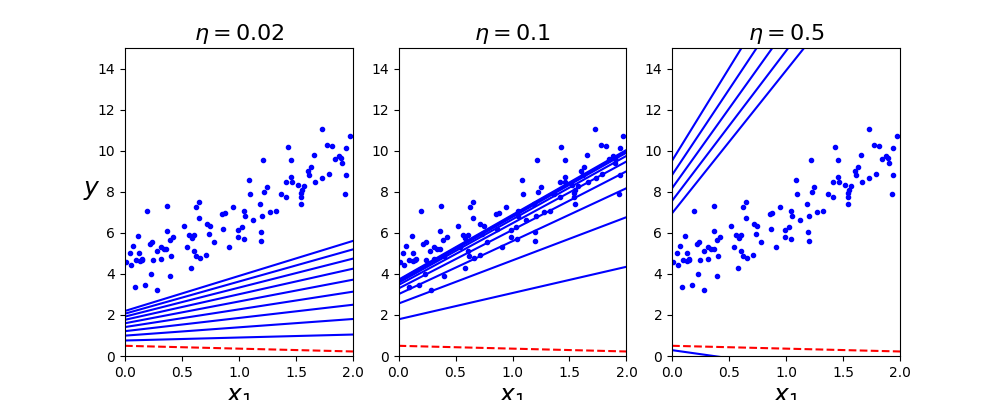

In [14]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

### Stochastic Gradient Descent

In [15]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

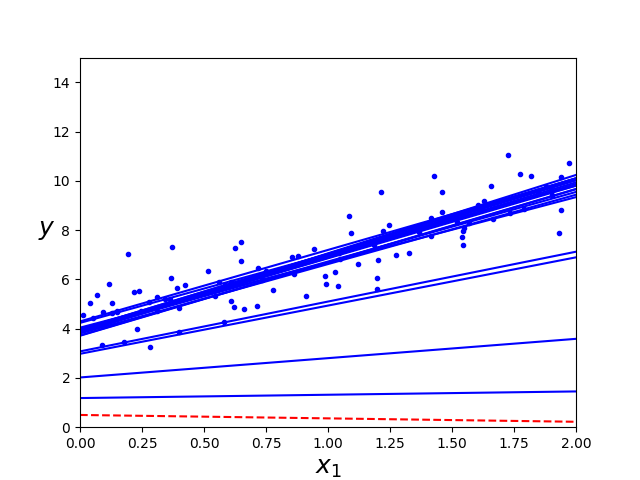

In [16]:
plt.figure()
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
plt.show()                                           # not shown

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

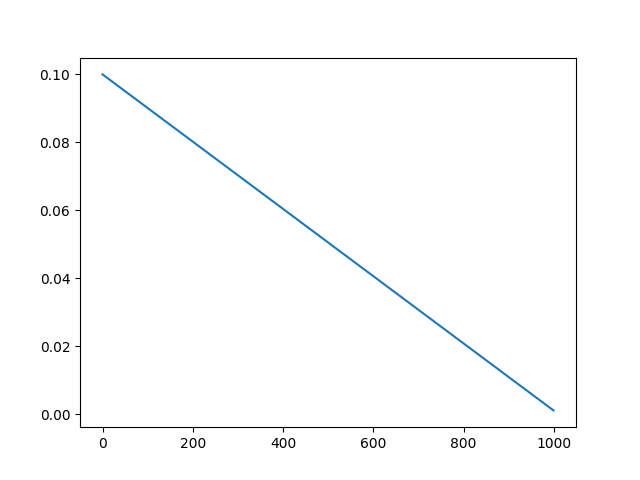

In [18]:
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return (t * 0.001 + (1000-t) * 0.1)/1000
#     return t0 / (t + t1)

ts_temp = np.arange(0, 1000)
lr_temp = [learning_schedule(ts) for ts in ts_temp]

plt.figure()
plt.plot(ts_temp, lr_temp)


How can we do that using sklearn?

In [19]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [20]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### Mini-batch gradient descent

In [21]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [22]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [23]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

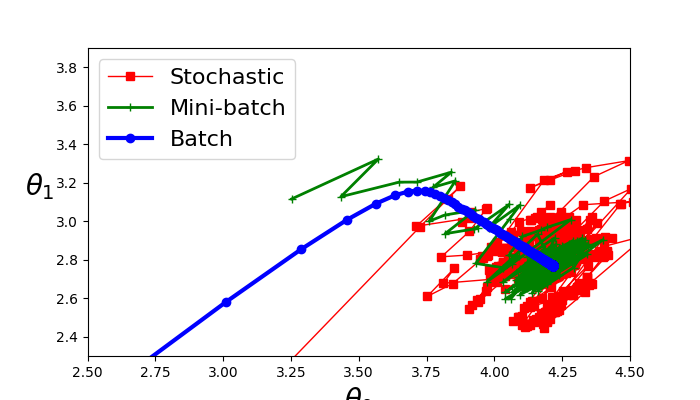

In [24]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

## Normal equation

The linear regression can be solved using the closed-form Normal Equation

$$\hat{\Theta}=(X^TX)^{-1}X^Ty$$

Where 
* $X$ is the input for all examples with ones appended to the features for the bias term. $X$ shape is $(m_{examples}, n_{feats}+1)$.
* $y$ is all the targets, i.e. $[y^{(1)}, y^{(2)}, ..., y^{(m)}]$


In [25]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

How to do the same using sklearn?

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [27]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [28]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

# Polynomial regression

In [29]:
import numpy as np
import numpy.random as rnd



In [30]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
X_new = np.linspace(-3, 3, 50).reshape(-1, 1)

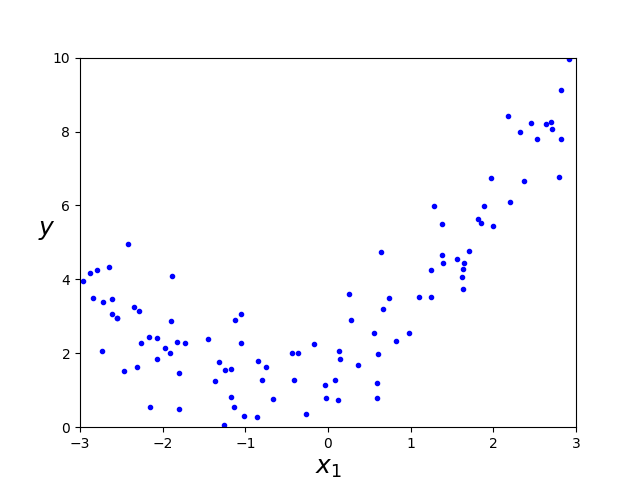

In [31]:
plt.figure()
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [32]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [33]:
X_poly[0, :]

array([-0.75275929,  0.56664654])

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

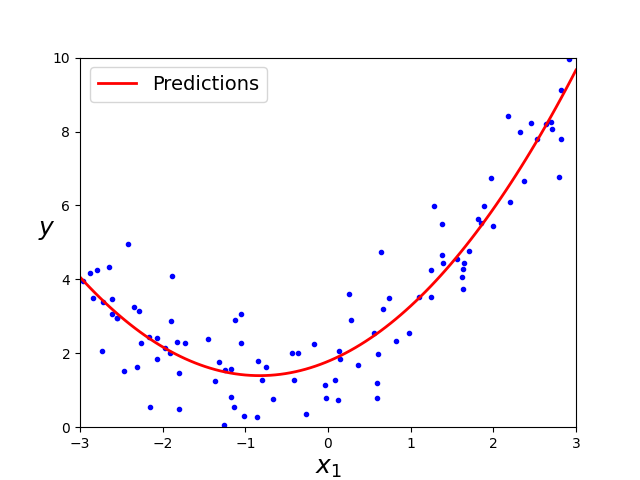

In [35]:
plt.figure()
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

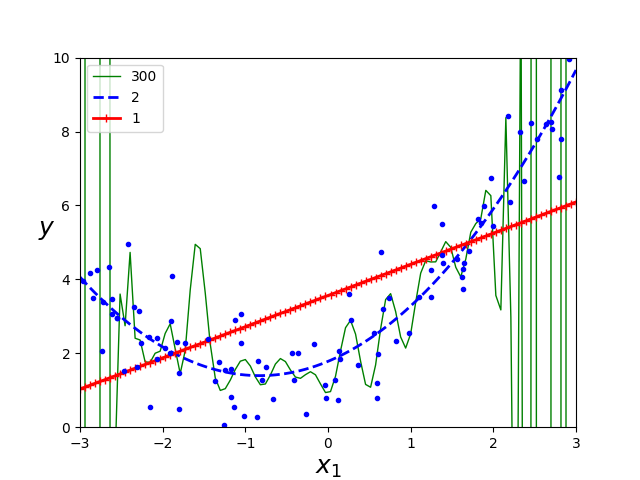

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

plt.figure()

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [37]:
# np.random.seed(42)
# m = 20
# data_gen_func = lambda X: 1 + 0.5 * X
# X = 3 * np.random.rand(m, 1)
# y = data_gen_func(X) + np.random.randn(m, 1) / 1.5
# X_new = np.linspace(0, 3, 100).reshape(100, 1)

### Regularization
What if we add penality to the norm of the parameters?

Ridge 
$$J(\Theta)=\frac{\sum_{i=1}^m (h(x^{(i)})-y^{(i)})^2}{m}+\alpha\frac{1}{2}{\sum_{i=1}^n (\theta^i)^2}$$

LASSO 
$$J(\Theta)=\frac{\sum_{i=1}^m (h(x^{(i)})-y^{(i)})^2}{m}+\alpha{\sum_{i=1}^n |\theta^i|}$$

ElasticNet
$$J(\Theta)=\frac{\sum_{i=1}^m (h(x^{(i)})-y^{(i)})^2}{m}+\frac{1-r}{2}\alpha{\sum_{i=1}^n (\theta^i)^2}+\frac{r}{2}\alpha{\sum_{i=1}^n |\theta^i|}$$

*It's important to notice that we don't regularize the bias term in these equations.*

interactive(children=(Dropdown(description='model_type', options=('Linear', 'Ridge', 'Lasso', 'ElasticNet'), v…

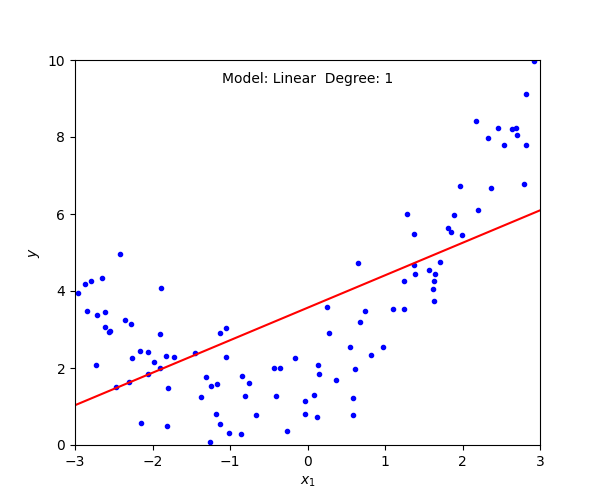

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# plt.figure()
# plt.plot(X, y, "b.")
fig = plt.figure(figsize=(6, 5))
axes = {
    "model": fig.add_subplot(),
}

axes["model"].set_xlim([-3, 3])
axes["model"].set_ylim([0, 10])
# axes["model"].set_xlim([0, 3])
# axes["model"].set_ylim([0, 3])
axes["model"].set_xlabel(r"$x_1$")
axes["model"].set_ylabel("$y$")

@widgets.interact(model_type=["Linear", "Ridge", "Lasso", "ElasticNet"],
                  degree=(1, 100, 1), 
                  alpha=widgets.FloatLogSlider(value=0, base=10, min=-3, max=3,
                                               step=0.2, description='alpha'), 
                  l1_ratio=(0.00001, 1, 0.1))
def update(model_type="Linear", degree=1, alpha=0, l1_ratio=0.5):
    [l.remove() for a in axes.values() for l in a.get_lines()]
    [c.remove() for a in axes.values() for c in a.collections]
    [t.remove() for t in axes["model"].texts]

    axes["model"].plot(X, y, "b.")
#     axes["model"].plot([0, 3], [data_gen_func(0), data_gen_func(1)], "y--")
    if model_type == "Linear" or alpha<1e-5:
        model_ins = LinearRegression()
        axes["model"].text(0.5, 0.95,r'Model: {}  Degree: {}'.format(model_type, degree), horizontalalignment='center',
             verticalalignment='center',
             transform=axes["model"].transAxes)
    elif model_type == "Ridge":
        model_ins = Ridge(alpha=alpha)
        axes["model"].text(0.5, 0.95,r'Model: {}  Degree: {}  Alpha: {:.03f}'.format(model_type, degree, alpha), horizontalalignment='center',
             verticalalignment='center',
             transform=axes["model"].transAxes)
    elif model_type == "Lasso":
        model_ins = Lasso(alpha=alpha, max_iter=10000)
        axes["model"].text(0.5, 0.95,r'Model: {}  Degree: {}  Alpha: {:.03f}'.format(model_type, degree, alpha), horizontalalignment='center',
             verticalalignment='center',
             transform=axes["model"].transAxes)
    elif model_type == "ElasticNet":
        model_ins = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=100000)
        axes["model"].text(0.5, 0.95,r'Model: {}  Degree: {}  Alpha: {:.03f}  l1_ratio: {:.03f}'.format(model_type, degree, alpha, l1_ratio), horizontalalignment='center',
             verticalalignment='center',
             transform=axes["model"].transAxes)

    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("model", model_ins),
    ])
    
    model.fit(X, y)
    y_new_regul = model.predict(X_new)
    axes["model"].plot(X_new, y_new_regul, "r", label=r"$\alpha = {}$".format(alpha))

    


In [39]:
plt.close()

### Learning curve to detect overfitting

We've learned to visually detetct the overfitting. We also used the validation set to check for overfitting by checking if there's a high difference between the performance measure of the model on the training set and the validation set.

We can use another approach to detect the overfitting, the learning curve. In the learning curve, the effect of the dataset size on the performance of the model on the training and the test set is depicted.

In [40]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

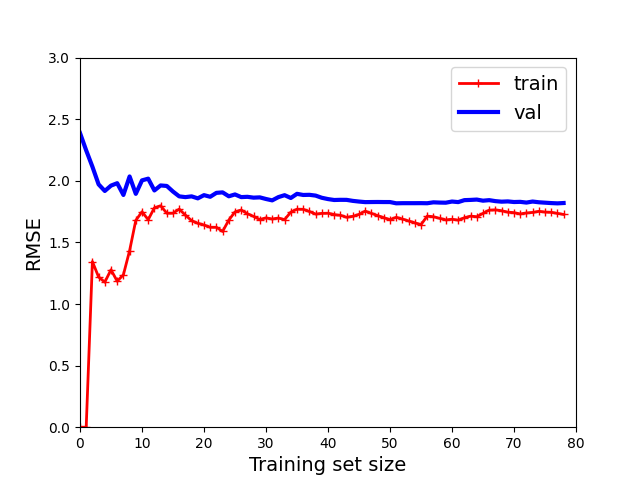

In [42]:
plt.figure()
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()                                      # not shown

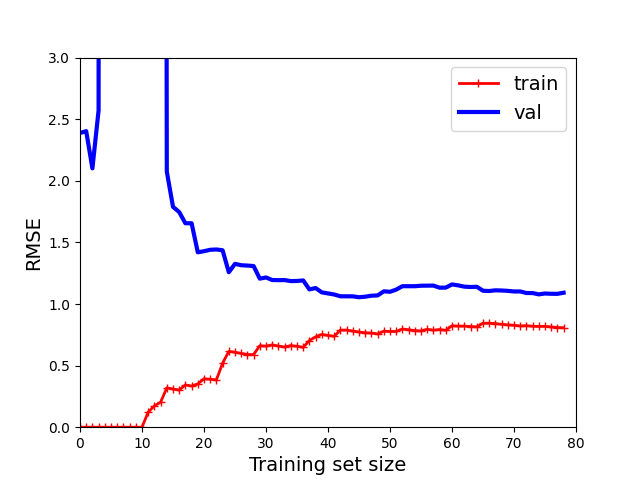

In [43]:
from sklearn.pipeline import Pipeline
plt.figure()
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
plt.show()                        # not shown

#### Bias VS Variance
Total error = Bias error + Variance error + Irreducible error

* Bias -> wrong assumption Underfitting.
* Variance -> Sensitivity to the small variation in the data.
* Irreducible error -> Noisiness of the data itself

### Early stopping

In [44]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [45]:
import warnings
warnings.simplefilter('always')


In [ ]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=0, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [ ]:
sgd_reg = SGDRegressor(max_iter=1, tol=0, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)
plt.figure()
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

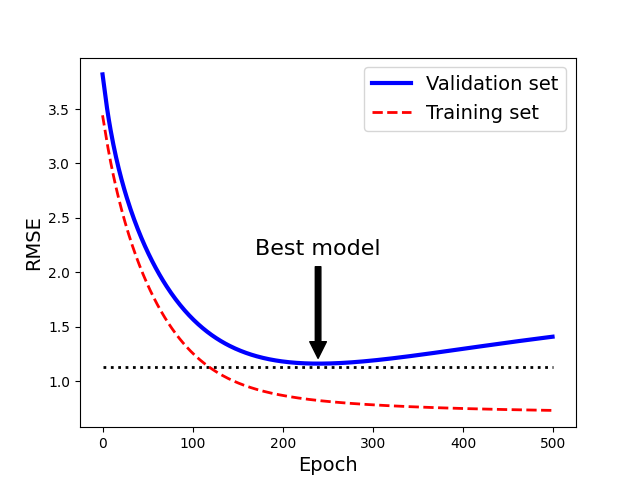

In [48]:
best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# save_fig("early_stopping_plot")
plt.show()

### L1 vs L2

In [49]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])


C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


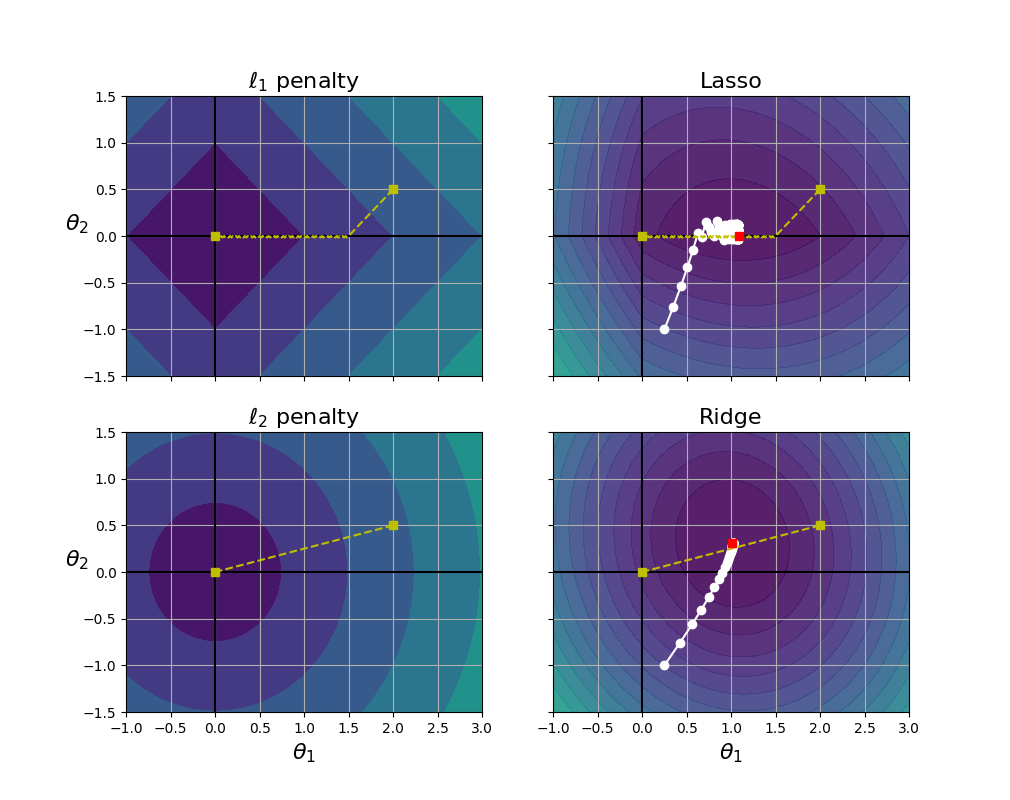

In [50]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

# Logistic regression

We can do classification with a small tweak in the linear regression model.
$$\hat{p}=h_{\Theta}(x)=\sigma(x^T\Theta)$$
Where $\sigma()$ is the logistic function,
$$\sigma(t)=\frac{1}{1+exp(-t)}$$


C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


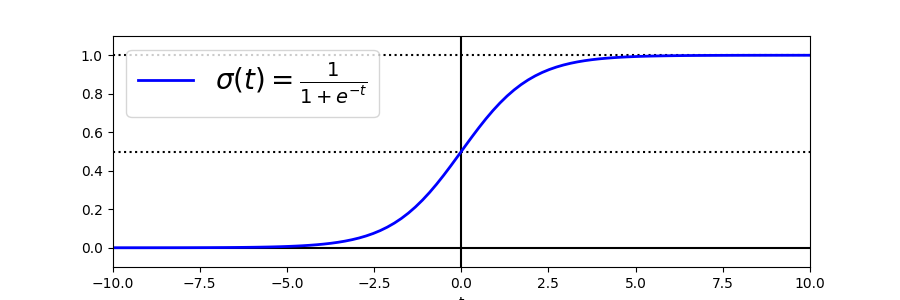

In [51]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

One loss functions that can be used for logistic regression is the *log loss*
$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^m [y^{(i)}\log(\hat{p}^{(i)})+(1-y^{(i)})\log(1-\hat{p}^{(i)})]$$

Partial derivatives
$$\frac{\partial {J(\theta)}}{\partial {\theta_j}}=\frac{1}{m}\sum_{i=1}^m (\sigma(\theta^Tx^{(i)}) - y^{(i)})x_j^{(i)}$$

<>:7: DeprecationWarning: invalid escape sequence \h
<>:8: DeprecationWarning: invalid escape sequence \l
<>:7: DeprecationWarning: invalid escape sequence \h
<>:8: DeprecationWarning: invalid escape sequence \l
C:\Users\aelaw\AppData\Local\Temp\ipykernel_10880\3537689613.py:7: DeprecationWarning: invalid escape sequence \h
  plt.xlabel("$\hat{p}$")
C:\Users\aelaw\AppData\Local\Temp\ipykernel_10880\3537689613.py:8: DeprecationWarning: invalid escape sequence \l
  plt.ylabel("$-\log{(p)}$")
C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


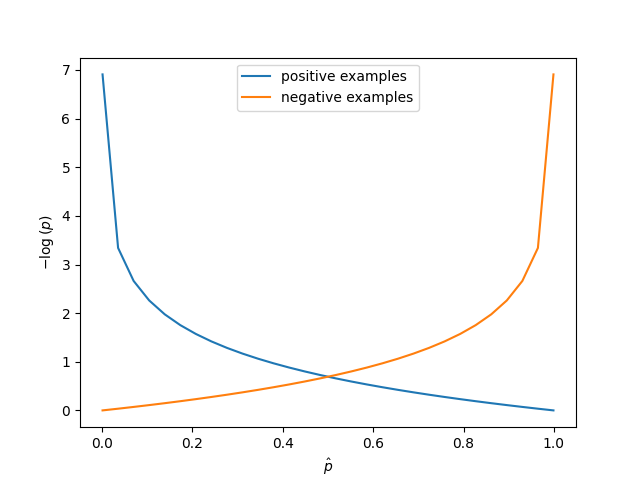

In [52]:
X_log = np.linspace(0.001, 0.999, 30)
y_log = -np.log(X_log)
plt.figure()
plt.plot(X_log, y_log, label="positive examples")
y_log = -np.log(1 - X_log)
plt.plot(X_log, y_log, label="negative examples")
plt.xlabel("$\hat{p}$")
plt.ylabel("$-\log{(p)}$")
plt.legend()

In [53]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [54]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype("int")  # 1 if Iris virginica, else 0

In [55]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


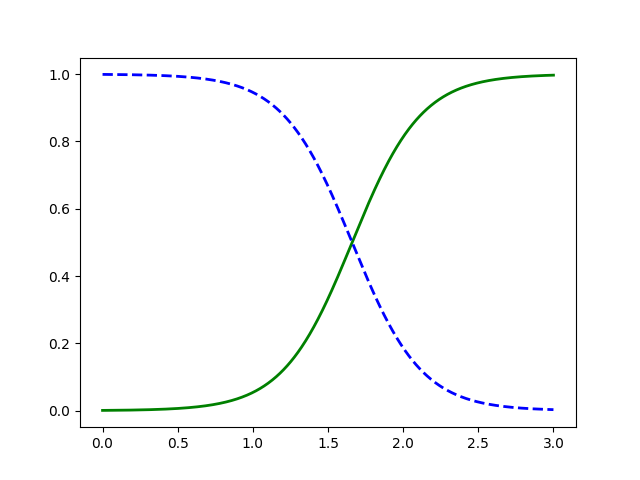

In [56]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.figure()
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


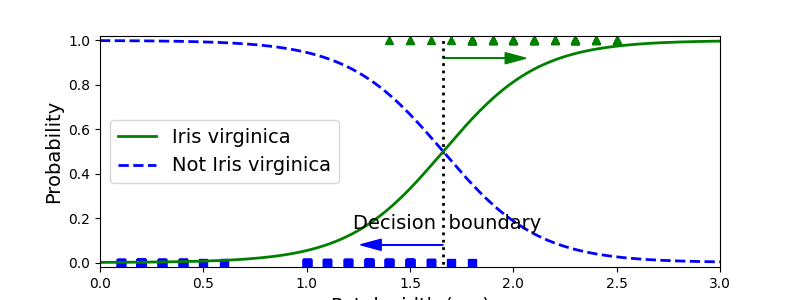

In [58]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [59]:
decision_boundary

array([1.66066066])

In [60]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


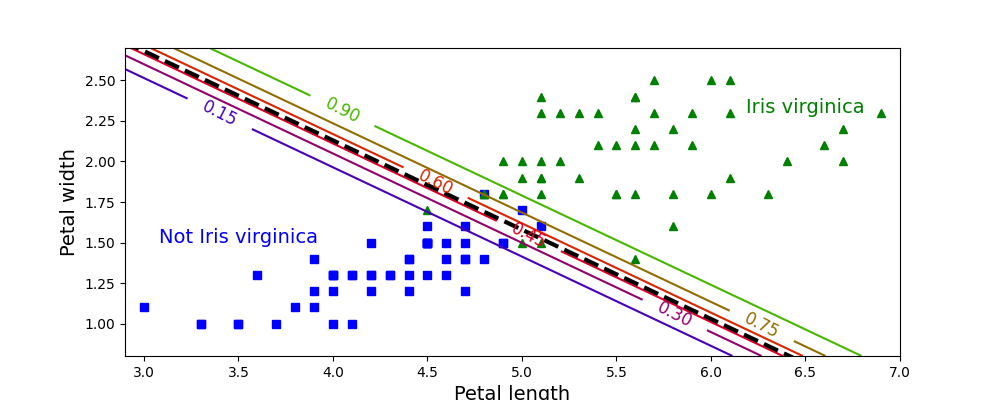

In [61]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype("int")

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

### Softmax
Score for each class
$$s_k(\boldsymbol{x})=\boldsymbol{x}^T\Theta^{(k)}$$

The output
$$\hat{p}_k=\frac{exp(s_k(\boldsymbol{x}))}{\sum_{j=1}^K exp(s_j(\boldsymbol{x}))}$$

The loss function
$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^Ky_k^{(i)}\log(\hat{p}_k^{(i)})$$

Partial derivatives
$$\nabla_{\Theta^{(k)}}{J(\Theta)}=\frac{1}{m}\sum_{i=1}^m (\hat{p}_k^{(i)} - y_k^{(i)})x^{(i)}$$

In [62]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

C:\Users\aelaw\venvs\homl_ml2\lib\site-packages\ipywidgets\widgets\widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


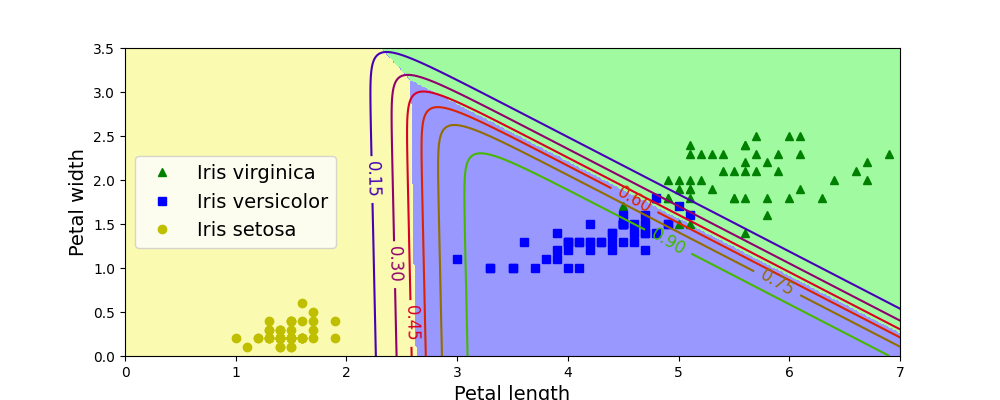

In [63]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [64]:
softmax_reg.predict([[5, 2]])

array([2])

In [65]:
softmax_reg.predict_proba([[5, 2]]).sum()

0.9999999999999999